# DCGAN Implementation on CelebA Dataset

In [1]:
# Importing necessary libraries

from __future__ import print_function
import random

import torch
import torchvision
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import argparse
import os
from tqdm import tqdm
import time
import copy
import math
from zipfile import ZipFile
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

In [2]:
# PyTorch's versions: (to ensure compatibility)
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
print("NumPy Version: ",np.__version__)

# interactive mode
plt.ion()

# to ensure reproducibility
manualSeed = 999
print('Random Seed: '  , manualSeed )
random.seed(manualSeed)
torch.manual_seed(manualSeed)

PyTorch Version:  2.5.1+cu121
Torchvision Version:  0.20.1+cu121
NumPy Version:  1.26.4
Random Seed:  999


In [3]:
# Root directory for dataset
root_dir = '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba'

config = { 'batch_size'        : 128,
           'image_size'        : 64,
           'n_channel'         : 3,
           'latent_space_size' : 100,
           'feature_mapG'      : 64,
           'feature_mapD'      : 64,
           'num_epochs'        : 5,
           'lr'                : 2e-4,
           'beta1'             : 0.5
 
}

# work with GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device : ' , device)

Device :  cuda


In [4]:
def timeit(Func):
    """
    Decorator to measure the execution time of a function.

    This decorator records the start time before calling the function and 
    calculates the elapsed time after execution. If the time exceeds 60 seconds, 
    it prints the duration in minutes and seconds; otherwise, it prints the time in seconds.

    Args:
        Func (function): The function whose execution time needs to be measured.

    Returns:
        function: A wrapped function that prints execution time upon completion.
    """
    def _timeStamp(*args, **kwargs):
        since = time.time()  # Record start time before function execution
        result = Func(*args, **kwargs)  # Execute the function
        time_elapsed = time.time() - since  # Compute elapsed time

        # Display time in minutes and seconds if execution exceeds 60 seconds
        if time_elapsed > 60:
            print('Time Consumed : {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))  
        else:        
            print('Time Consumed :', round(time_elapsed, 4), 's')  # Otherwise, show time in seconds
        
        return result  # Return the function's output
    return _timeStamp  # Return the wrapped function

In [5]:
class CelebrityData(torch.utils.data.Dataset):
    """
    Custom PyTorch Dataset for the CelebA dataset.

    This dataset class loads images from a specified directory and 
    applies transformations if provided.

    Args:
        root_dir (str): Path to the directory containing images.
        transform (callable, optional): A function/transform to apply to images.

    Attributes:
        root_dir (str): Directory where the dataset images are stored.
        transform (callable): Transformations to apply to images.
        ListOfImages (list): List of image file paths in the dataset.
    """

    def __init__(self, root_dir, transform=None):
        """
        Initializes the dataset by storing the directory path and 
        listing all image files inside the folder.

        Args:
            root_dir (str): Path to the dataset folder containing images.
            transform (callable, optional): Image transformations.
        """
        self.root_dir = root_dir  # Store the dataset directory path
        self.transform = transform  # Store the transformation function (if any)

        # List all image file names in the directory
        self.ListOfImages = sorted(os.listdir(self.root_dir))  

    def __getitem__(self, index):
        """
        Loads and returns an image from the dataset at the given index.

        Args:
            index (int): Index of the image to retrieve.

        Returns:
            torch.Tensor: Transformed image.
        """
        # Construct full path to the image
        image_path = os.path.join(self.root_dir, self.ListOfImages[index])
        
        # Open the image and convert it to RGB format
        image = Image.open(image_path).convert('RGB')

        # Apply transformations if provided
        if self.transform is not None:
            image = self.transform(image)

        return image

    def __len__(self):
        """
        Returns the total number of images in the dataset.

        Returns:
            int: Number of images in the dataset.
        """
        return len(self.ListOfImages)

In [6]:
# Define the dataset with data augmentation for better generalization
celebrity_dataset = CelebrityData(
    root_dir,  # Path to images
    transform=transforms.Compose([
        transforms.ColorJitter(brightness=0.9, contrast=0.9),  # Randomly adjust brightness & contrast
        transforms.RandomGrayscale(p=0.3),  # Convert to grayscale with 30% probability
        transforms.RandomAffine(degrees=(-30, 30)),  # Random rotation between -30 and 30 degrees
        transforms.RandomPerspective(distortion_scale=0.5, p=0.5),  # Apply random perspective transformation
        transforms.GaussianBlur(kernel_size=3),  # Apply Gaussian blur
        transforms.RandomHorizontalFlip(p=0.2),  # Horizontally flip 20% of the time
        transforms.RandomVerticalFlip(p=0.2),  # Vertically flip 20% of the time
        
        # Essential transformations
        transforms.Resize(int(config['image_size'] * 1.1)),  # Resize slightly larger than target size
        transforms.CenterCrop(config['image_size']),  # Crop to exact size
        transforms.ToTensor(),  # Convert image to tensor
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # Normalize to [-1,1] range
    ])
)

# Define DataLoader for efficient batch loading
dataloader = torch.utils.data.DataLoader(
    dataset=celebrity_dataset,
    shuffle=True,  # Shuffle the dataset for randomness
    batch_size=config['batch_size'],  # Set batch size from config
    num_workers=2,  # Use two worker threads for loading
    drop_last=True,  # Drop last batch if it’s smaller than batch_size
    pin_memory=True  # Improve GPU performance by keeping tensors in pinned memory
)

print(f"Dataset Size: {len(celebrity_dataset)} images")
print(f"Batches per epoch: {len(dataloader)}")

Dataset Size: 202599 images
Batches per epoch: 1582


In [7]:
def weights_init(m):
    """
    Custom weight initialization function for the generator (netG) and discriminator (netD).
    
    This function initializes:
    - Convolutional layers (`Conv` in name) with a normal distribution (mean=0, std=0.02).
    - Batch Normalization layers (`BatchNorm` in name) with:
      - Weights initialized from a normal distribution (mean=1, std=0.02).
      - Biases initialized to zero.
    
    Args:
        m (torch.nn.Module): A layer of the model, passed automatically by PyTorch's apply() function.
    
    Returns:
        None (Modifies model parameters in-place).
    """
    classname = m.__class__.__name__  # Get the name of the layer's class
    
    if classname.find('Conv') != -1:
        # Initialize Convolutional layers with a normal distribution (mean=0, std=0.02)
        nn.init.normal_(m.weight.data, mean=0.0, std=0.02)

    elif classname.find('BatchNorm') != -1:
        # Initialize BatchNorm weights with a normal distribution (mean=1, std=0.02)
        nn.init.normal_(m.weight.data, mean=1.0, std=0.02)
        # Set BatchNorm biases to 0
        nn.init.constant_(m.bias.data, 0)

In [8]:
class Generator(nn.Module):
    """
    Deep Convolutional GAN (DCGAN) Generator.
    
    This class defines the generator model, which takes a latent space vector (random noise)
    and generates a 64x64 RGB image.

    Architecture:
    - Uses `ConvTranspose2d` layers for upsampling.
    - Uses `BatchNorm2d` to stabilize training.
    - Uses `ReLU` activation in hidden layers and `Tanh` activation for the output.
    
    Args:
        latent_space_size (int): Size of the latent space (input noise vector).
        ngf (int): Number of feature maps in the first convolutional layer.
        n_channel (int): Number of output channels (e.g., 3 for RGB images).
    
    Returns:
        Tensor: Generated image of shape (n_channel, 64, 64).
    """

    def __init__(self, latent_space_size=config['latent_space_size'],
                 ngf=config['feature_mapG'], n_channel=config['n_channel']):

        super(Generator, self).__init__()

        self.generator = nn.Sequential(
            # First layer: Latent vector (Z) → feature maps
            # Input: (latent_space_size) x 1 x 1
            nn.ConvTranspose2d(latent_space_size, ngf * 8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf * 8),  # Normalize activations to stabilize training
            nn.ReLU(True),  # Apply ReLU activation to introduce non-linearity
            # Output: (ngf*8) x 4 x 4

            # Second layer: Upsampling to 8x8
            nn.ConvTranspose2d(ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # Output: (ngf*4) x 8 x 8

            # Third layer: Upsampling to 16x16
            nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # Output: (ngf*2) x 16 x 16

            # Fourth layer: Upsampling to 32x32
            nn.ConvTranspose2d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # Output: (ngf) x 32 x 32

            # Final layer: Upsampling to 64x64, output RGB image
            nn.ConvTranspose2d(ngf, n_channel, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()  # Tanh activation ensures output pixel values are in the range [-1, 1]
            # Output: (n_channel) x 64 x 64
        )

    def forward(self, inp):
        """
        Forward pass of the generator.
        
        Args:
            inp (Tensor): Latent space input tensor of shape (batch_size, latent_space_size, 1, 1).
        
        Returns:
            Tensor: Generated image of shape (batch_size, n_channel, 64, 64).
        """
        return self.generator(inp)

In [9]:
# Initialize the Generator and move it to the specified device (CPU/GPU)
netG = Generator().to(device)

# If multiple GPUs are available, use DataParallel to distribute the model across them
if (device.type == 'cuda') and torch.cuda.device_count() > 1:
    netG = nn.DataParallel(netG, list(range(torch.cuda.device_count())))

# Apply custom weight initialization to the generator
netG.apply(weights_init)

Generator(
  (generator): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
 

In [10]:
batch = next(iter(dataloader))  # Fetch the first batch from the DataLoader
print(batch.size())  # Print the size of the batch

torch.Size([128, 3, 64, 64])


In [11]:
class Discriminator(nn.Module):
    """
    Discriminator network for a Deep Convolutional GAN (DCGAN).
    
    This class defines a convolutional neural network that takes an image as input
    and outputs a probability score indicating whether the image is real (from the dataset) 
    or fake (generated by the Generator).
    
    Args:
        n_channel (int): Number of channels in the input image (e.g., 3 for RGB).
        ndf (int): Number of feature maps in the first convolutional layer.
    """

    def __init__(self, n_channel=config['n_channel'], ndf=config['feature_mapD']):
        super(Discriminator, self).__init__()

        # Define the convolutional layers for the discriminator
        self.discriminator = nn.Sequential(
            # Input: (n_channel) x 64 x 64 → Output: (ndf) x 32 x 32
            nn.Conv2d(n_channel, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # Input: (ndf) x 32 x 32 → Output: (ndf * 2) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # Input: (ndf * 2) x 16 x 16 → Output: (ndf * 4) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # Input: (ndf * 4) x 8 x 8 → Output: (ndf * 8) x 4 x 4
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            # Input: (ndf * 8) x 4 x 4 → Output: (1) x 1 x 1 (Single probability score)
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()  # Outputs a probability value (0 = fake, 1 = real)
        )

    @staticmethod
    def linear_block(in_ftrs, out_ftrs, p):
        """
        Creates a fully connected block with batch normalization, ReLU activation, and dropout.

        Args:
            in_ftrs (int): Number of input features.
            out_ftrs (int): Number of output features.
            p (float): Dropout probability.

        Returns:
            nn.Sequential: A sequential block consisting of Linear, BatchNorm, ReLU, and Dropout.
        """
        return nn.Sequential(
            nn.Linear(in_ftrs, out_ftrs),
            nn.BatchNorm1d(out_ftrs),
            nn.ReLU(),
            nn.Dropout(p)
        )

    def forward(self, inp):
        """
        Forward pass of the Discriminator.
        
        Args:
            inp (torch.Tensor): Input image tensor of shape (batch_size, n_channel, 64, 64).
        
        Returns:
            torch.Tensor: Output tensor containing probability scores for real vs fake.
        """
        return self.discriminator(inp)

In [12]:
netD = Discriminator().to(device)

# Handle multi-GPU if available
if (device.type == 'cuda') and (torch.cuda.device_count() > 1):
    netD = nn.DataParallel(netD, list(range(torch.cuda.device_count())))

netD.apply(weights_init)

Discriminator(
  (discriminator): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [13]:
# Define the Binary Cross Entropy Loss (BCELoss) for training the Discriminator
criterion = nn.BCELoss().to(device)

# Fixed noise vector (latent space input) for tracking generator progress during training
fixed_noise = torch.randn(64, config['latent_space_size'], 1, 1, device=device)

# Print the shape of the fixed noise tensor to confirm its dimensions
print(fixed_noise.size())  

# Define labels for real and fake images
real_label = 1.0  # Label for real images
fake_label = 0.0  # Label for generated (fake) images

# Define the Adam optimizer for the Discriminator (netD)
optimizerD = optim.Adam(
    netD.parameters(),  # Parameters to optimize
    lr=config['lr'],  # Learning rate
    betas=(config['beta1'], 0.999)  # Adam's beta values for momentum estimates
)

# Define the Adam optimizer for the Generator (netG)
optimizerG = optim.Adam(
    netG.parameters(),  # Parameters to optimize
    lr=config['lr'],  # Learning rate
    betas=(config['beta1'], 0.999)  # Adam's beta values for momentum estimates
)

torch.Size([64, 100, 1, 1])


In [15]:
output_dir = '/kaggle/working/'

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")

try :
  if os.path.exists(os.path.join(root_dir,'GAN','GAN_Models','Custom_DCGAN') + '.pth'):
    print('Wearing weights ...')
    checkpoint = torch.load(os.path.join(root_dir,'GAN','GAN_Models','Custom_DCGAN') + '.pth')
    netG.load_state_dict(checkpoint['Generator_state_dict'])
    netD.load_state_dict(checkpoint['Discriminator_state_dict'])  
    netG.to(device)
    netD.to(device)

except RuntimeError as rtr:
  print('Saved Model cannot be loaded...')


# For each epoch
for epoch in range(config['num_epochs']):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data.to(device)
        
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)


        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, config['num_epochs'], i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == config['num_epochs']-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                           
              
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
           

        iters += 1

In [17]:
if not os.path.exists(os.path.join(output_dir,'GAN','GAN_Models')):
  os.mkdir('GAN_Models')

In [19]:
torch.save({'Generator_state_dict' : netG.state_dict(),
            'Discriminator_state_dict' : netD.state_dict(),
            'Generator_optim_state_dict' : optimizerG.state_dict(),
            'Discriminator_optim_state_dict' : optimizerD.state_dict(),
              },           
            os.path.join(output_dir,'GAN_Models','Custom_DCGAN') + ".pth")

In [21]:
if os.path.exists(os.path.join(output_dir,'GAN_Models','Custom_DCGAN') + '.pth'):
  print('Wearing weights ...')
  checkpoint = torch.load(os.path.join(output_dir,'GAN_Models','Custom_DCGAN') + '.pth')
  netG.load_state_dict(checkpoint['Generator_state_dict'])
  netD.load_state_dict(checkpoint['Discriminator_state_dict'])  
  netG.to(device)
  netD.to(device)

Wearing weights ...


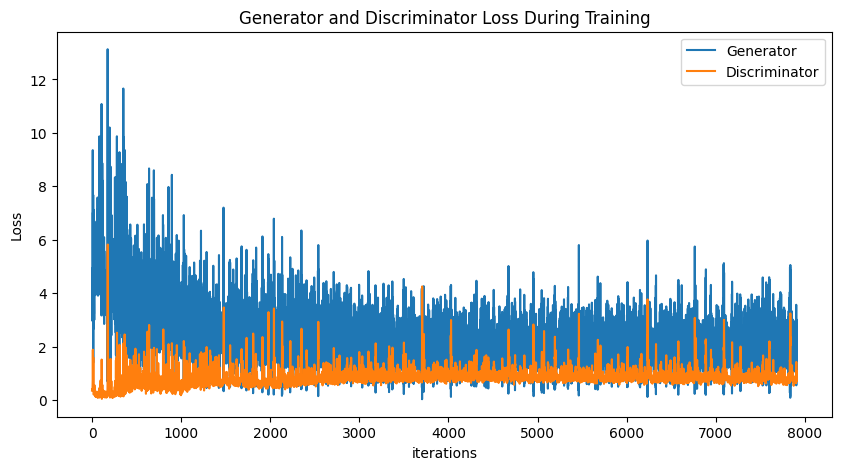

In [22]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="Generator")
plt.plot(D_losses,label="Discriminator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Visualizing

with torch.no_grad():
  netG.eval()
  fakes = netG(torch.randn(256,100,1,1, dtype = torch.float , device = device))

plt.figure(figsize = (20,35))
plt.axis('off')
plt.imshow(vutils.make_grid(fakes, padding=2, normalize=True , nrow= 16).cpu().permute(1,2,0))

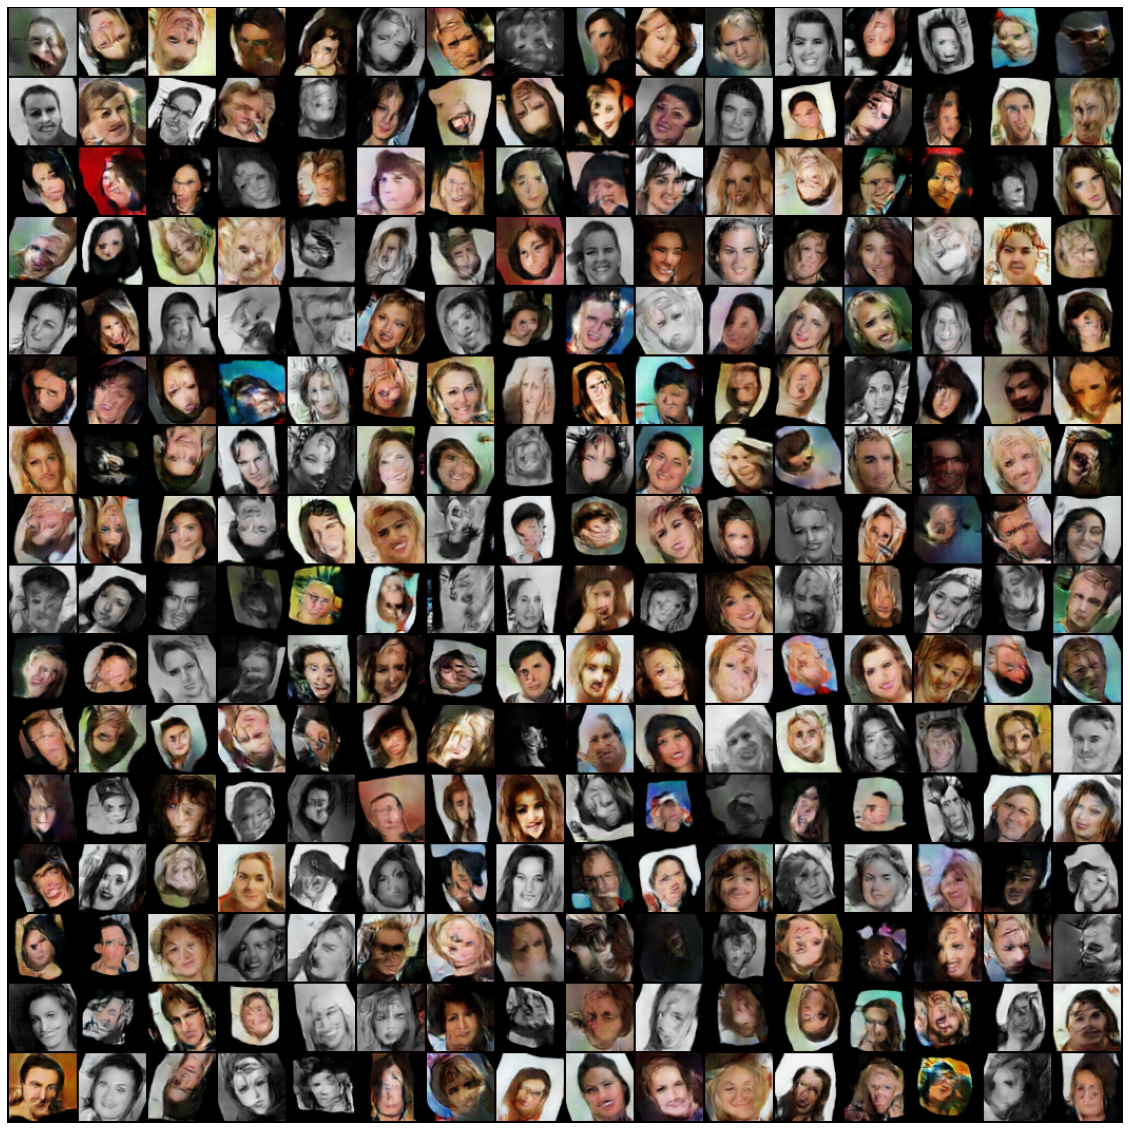
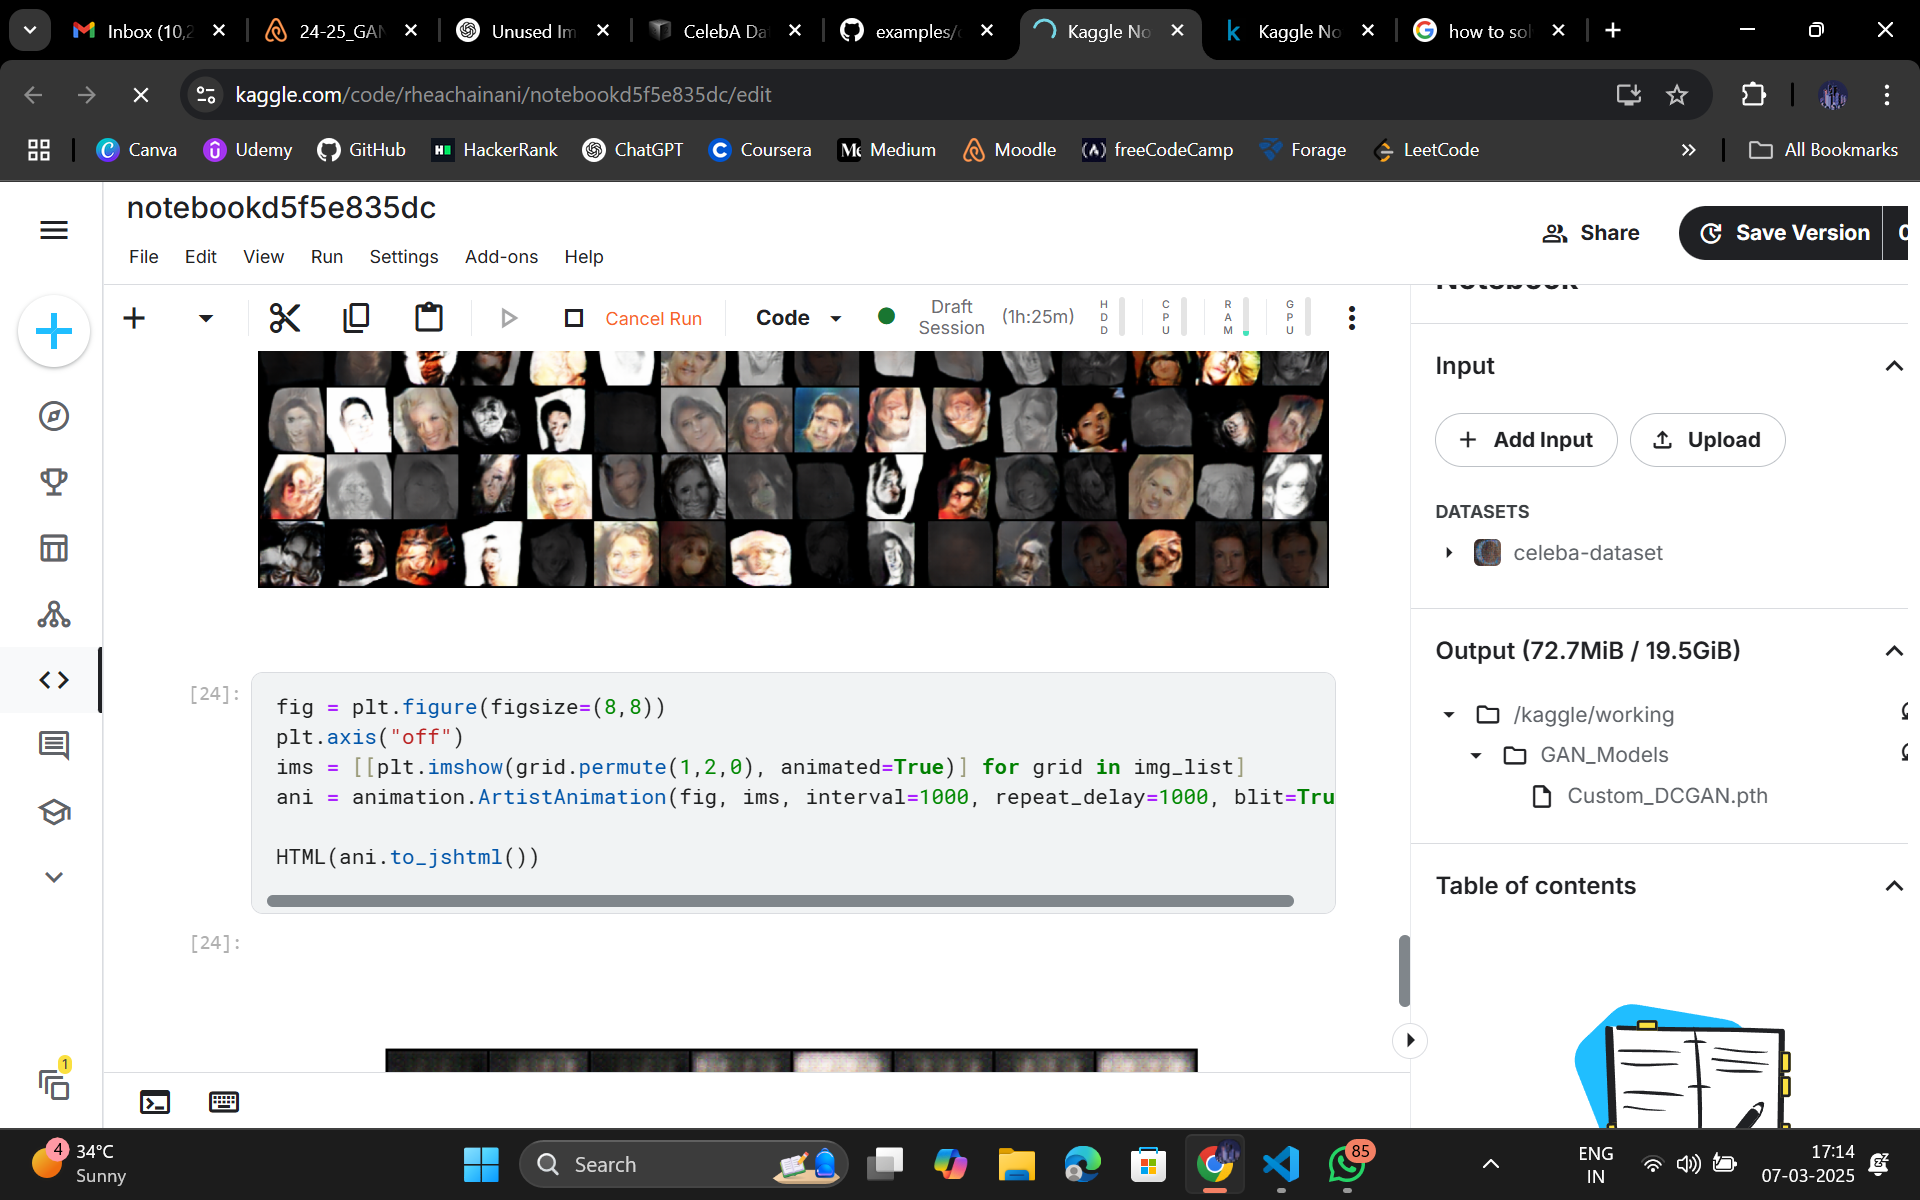

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(grid.permute(1,2,0), animated=True)] for grid in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

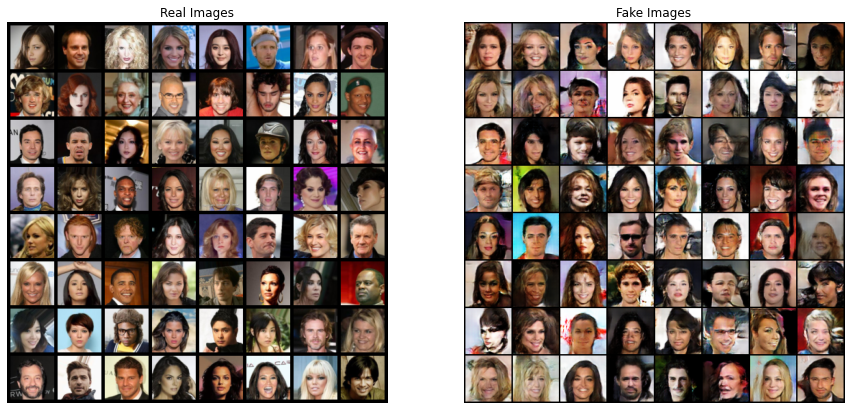